Чтобы потренироваться в применении основных алгоритмов кластеризации возьмем датасет с уже размеченными классами.
В этом датасете приводятся обработанные спутниковые снимки местности.
Снимки классифицируются по типам растительности шести видов (занумерованными цифрами 1,2,3,4,5,7). 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
dataTrain = pd.read_csv("sat.trn", header = None, sep='\s+')
dataTest = pd.read_csv("sat.tst", header = None, sep='\s+')
data = dataTrain.append(dataTest, ignore_index = True)

In [3]:
data.describe()


,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
count,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,...,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,69.400000,83.594872,99.290598,82.592696,69.150272,83.243512,99.110645,82.497125,68.912354,82.893085,...,82.660606,68.944056,83.145610,99.111888,82.618026,68.727584,82.858897,98.926030,82.505361,3.668687
std,13.605871,22.882234,16.645944,18.897674,13.561197,22.886495,16.664088,18.940923,13.470599,22.862255,...,18.991281,13.492684,22.847199,16.704305,19.043661,13.401603,22.816959,16.695488,19.054274,2.214052
min,39.000000,27.000000,53.000000,33.000000,39.000000,27.000000,50.000000,29.000000,40.000000,27.000000,...,29.000000,39.000000,27.000000,50.000000,29.000000,39.000000,27.000000,50.000000,29.000000,1.000000
25%,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,...,69.000000,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,85.000000,68.000000,2.000000
50%,68.000000,87.000000,101.000000,81.000000,68.000000,85.000000,101.000000,81.000000,67.000000,85.000000,...,81.000000,68.000000,85.000000,100.000000,81.000000,67.000000,84.000000,100.000000,81.000000,3.000000
75%,80.000000,103.000000,113.000000,92.000000,80.000000,103.000000,113.000000,92.000000,79.000000,102.000000,...,92.000000,79.000000,103.000000,113.000000,92.000000,79.000000,103.000000,113.000000,92.000000,5.000000
max,104.000000,137.000000,140.000000,154.000000,104.000000,137.000000,145.000000,157.000000,104.000000,130.000000,...,154.000000,104.000000,130.000000,145.000000,157.000000,104.000000,130.000000,145.000000,157.000000,7.000000


Видим, что целевой признак - в последнем столбце.

In [4]:
data.shape

(6435, 37)

In [5]:
data[data.columns[-1,]].value_counts()

1    1533
7    1508
3    1358
5     707
2     703
4     626
Name: 36, dtype: int64

In [6]:
df = data.drop(data.columns[-1,], axis=1)

In [7]:
classes = data[data.columns[-1,]].values.tolist()

### Предобработка

Промасштабируем признаки:

In [8]:
X = StandardScaler().fit_transform(df)

## ML

Для оценки качества кластеризации будем использовать следующие индексы:
- индекс достоверности $S\_Dbw$, 
$$
S\_Dbw = Scatt + Dens\_bw,
$$
где $Scatt$ - среднее рассеяние для кластеров, а $Dens\_bw$ - межкластерная плотность;
- коэффициент силуэта, $silhouette\_score$.

Для оценки того, хорошо ли наше разбиение на кластеры соответствует "истинному" разбиению на классы будем использовать скорректированный индекс Rand, $adjusted\_rand\_score$.

In [9]:
from sklearn.neighbors import NearestNeighbors

In [10]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [11]:
from s_dbw import S_Dbw

In [12]:
range_n_clusters = range(2, 12)
adjRSdf = pd.DataFrame(index = range_n_clusters)
adjSltdf = pd.DataFrame(index = range_n_clusters)
adjSDbwdf = pd.DataFrame(index = range_n_clusters)

### DBSCAN

Для заданного числа соседей будем искать значение $\varepsilon$ методом 'локтя' по упорядоченному массиву средних дистанций до соседей. Для этого введем следующую функцию:

In [13]:
def set_eps(X, n_neighbors, metric) :
    nbrs = NearestNeighbors(n_neighbors = n_neighbors, algorithm = 'auto', metric = metric, n_jobs = -1).fit(X)
    distances, indices = nbrs.kneighbors(X)
    dm = np.mean(distances, axis = 1)
    dms = np.sort(dm)
    D = np.abs(dms[2:]-dms[1:-1]) / np.abs(dms[1:-1]-dms[:-2])
    argEps = D.argmin()
    eps = dms[argEps]
    return eps

Будем искать экстремум заданного индекса - оценки проиводительности кластеризации,  варьируя число соседей и величину $\varepsilon$ около найденного его значения по методу "локтя" ($dr=1$ в случае минимизации индекса и
$dr = -1$ в случае его максимизации).

In [14]:
def best_DBSCAN_score(X, n_neigh_range, metric, score, dr):
    best = {'scoreBest': dr * np.infty, 'epsBest': 0., 'nNghbBest': 0}
    for nNghb in n_neigh_range:
        print("n_neighbors : %d" % nNghb)
        eps = set_eps(X, nNghb, metric)
        
        for mult in [0.9, 1., 1.1]:
            eps1 = mult * eps
            print("  eps : %0.3f" % eps1)
            db = DBSCAN(eps = eps1, min_samples = nNghb, metric = metric, n_jobs = -1).fit(X)
            labels = db.labels_
    
            if len(set(labels)) > 1:         
                sc = score(X, labels, metric = metric)
                
                if dr * sc < dr * best['scoreBest']:
                    best['scoreBest'] = sc
                    best['nNghbBest'] = nNghb
                    best['epsBest'] = eps1
                    print("  score: %0.3f" % sc)
    return best

In [15]:
def DBSCAN_report(best_par, metric) :
    db = DBSCAN(eps = best_par['epsBest'], min_samples = best_par['nNghbBest'], metric = metric, n_jobs = -1).fit(X)
    labels = db.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("SDbw score: %0.3f" % S_Dbw(X, labels, metric = metric))
    print('Silhouette score: %0.3f' % silhouette_score(X, labels, metric = metric))
    print('Adjusted rand score: %0.3f' % adjusted_rand_score(classes, labels))
    return labels

In [16]:
n_neigh_range = range(6,10)
metric= 'euclidean'

Сначала попробуем минимизировать индекс $S\_Dbw$.

In [17]:
best_S_Dbw = best_DBSCAN_score(X, n_neigh_range, metric, S_Dbw, 1)

n_neighbors : 6
  eps : 0.850
  score: 0.121
  eps : 0.944
  eps : 1.039
n_neighbors : 7
  eps : 1.786
  eps : 1.984
  eps : 2.182
n_neighbors : 8
  eps : 0.914
  eps : 1.016
  eps : 1.118
n_neighbors : 9
  eps : 0.850
  score: 0.109
  eps : 0.945
  eps : 1.039


In [18]:
labels = DBSCAN_report(best_S_Dbw, metric)

Estimated number of clusters: 6
Estimated number of noise points: 6362
SDbw score: 0.109
Silhouette score: -0.117
Adjusted rand score: -0.002


Видим, что хотя количество кластеров определилось правильно, но почти все точки оказались "шумом".

In [19]:
np.unique(labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5]),
 array([6362,   18,    6,   23,    6,   10,   10]))

Теперь посмотрим, что дает максимизация индекса $silhouette\_score$.

In [20]:
best_silhouette = best_DBSCAN_score(X, n_neigh_range, metric, silhouette_score, -1)

n_neighbors : 6
  eps : 0.850
  score: -0.108
  eps : 0.944
  eps : 1.039
n_neighbors : 7
  eps : 1.786
  eps : 1.984
  score: 0.188
  eps : 2.182
n_neighbors : 8
  eps : 0.914
  eps : 1.016
  eps : 1.118
n_neighbors : 9
  eps : 0.850
  eps : 0.945
  eps : 1.039


In [21]:
labels = DBSCAN_report(best_silhouette, metric)

Estimated number of clusters: 4
Estimated number of noise points: 638
SDbw score: 0.495
Silhouette score: 0.188
Adjusted rand score: 0.100


Видим, что все найденные индексы далеки от своих наилучших значений.

In [22]:
np.unique(labels, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([ 638, 5376,  407,    7,    7]))

## KMeans

In [23]:
SDbw = []
silhouette = []
adjRandSc = []
 
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters = n_clusters, n_jobs = -1, verbose = 1, random_state = 42) 
    labels = km.fit_predict(X)
    SDbws = S_Dbw(X, labels)
    SDbw.append(SDbws)
    silhouette_avg = silhouette_score(X, labels)
    silhouette.append(silhouette_avg)
    adjRandSc_avg = adjusted_rand_score(classes, labels)
    adjRandSc.append(adjRandSc_avg)    

Text(0, 0.5, 'silhouette score')

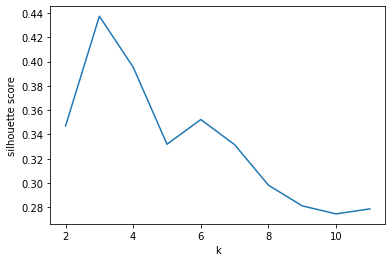

In [24]:
plt.plot(range_n_clusters,  silhouette)
plt.xlabel('k')
plt.ylabel('silhouette score')

Text(0, 0.5, 'S_Dbw')

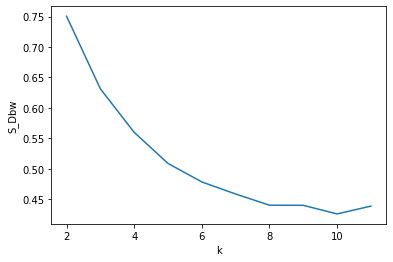

In [25]:
plt.plot(range_n_clusters,  SDbw)
plt.xlabel('k')
plt.ylabel('S_Dbw')

Text(0, 0.5, 'adj. Rand score')

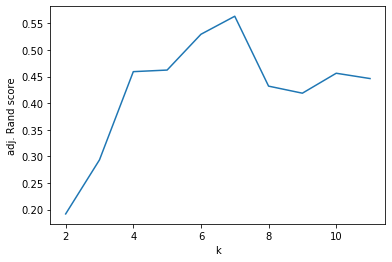

In [26]:
plt.plot(range_n_clusters,  adjRandSc)
plt.xlabel('k')
plt.ylabel('adj. Rand score')

In [27]:
adjRSdf['kMeans'] = adjRandSc
adjSltdf['kMeans'] = silhouette
adjSDbwdf['kMeans'] = SDbw
kMeansDf = pd.DataFrame(adjRandSc, range_n_clusters, ['adj. Rand score'])
kMeansDf['Silhouette'] = silhouette
kMeansDf['S_Dbw'] = SDbw
kMeansDf

,adj. Rand score,Silhouette,S_Dbw
2,0.191959,0.346910,0.750592
3,0.293505,0.437332,0.631317
4,0.459169,0.395397,0.559879
5,0.462151,0.331865,0.508784
6,0.529365,0.352249,0.478403
7,0.563240,0.331512,0.458585
8,0.431974,0.298151,0.440188
9,0.418721,0.281106,0.440011
10,0.456179,0.274483,0.425892
11,0.446201,0.278656,0.438713


Мы видим, что метод kMeans по-другому "отработал" на данном датасете, чем DBSCAN:
индекс $adjusted\_rand\_score$ близок на "правильном" количестве кластеров (k=6) к своему максимальному значению,
индекс $silhouette$ имеет локальный максимум при k=6, при этом индекс  $S\_Dbw$ стал хуже.

## GMM

Для оценки качества кластеризации методом GMM будем также использовать BIC (байесовский информационный критерий).

In [28]:
lowest_bic = np.infty
bic = []
adjRandSc = []
silhouette = []

SDbw = []
for n_components in range_n_clusters:
    gmm = GaussianMixture(n_components = n_components, verbose = 1, random_state = 42)
    gmm.fit(X)
    labels = gmm.predict(X)
    bic_cur = gmm.bic(X)
    bic.append(bic_cur)
    silhouette_avg = silhouette_score(X, labels)
    silhouette.append(silhouette_avg)
    adjRandSc_avg = adjusted_rand_score(classes, labels)
    adjRandSc.append(adjRandSc_avg)
    SDbws = S_Dbw(X, labels)
    SDbw.append(SDbws)

Initialization 0
  Iteration 10
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


Text(0, 0.5, 'adjusted_rand_score')

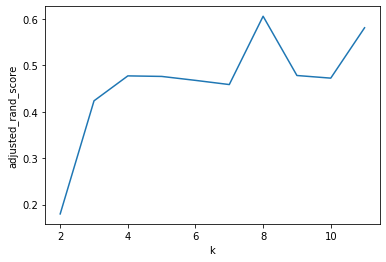

In [29]:
plt.plot(range_n_clusters,  adjRandSc)
plt.xlabel('k')
plt.ylabel('adjusted_rand_score')

Text(0, 0.5, 'BIC')

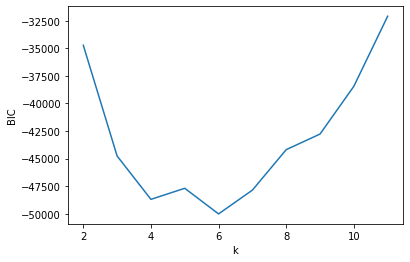

In [30]:
plt.plot(range_n_clusters,  bic)
plt.xlabel('k')
plt.ylabel('BIC')

Text(0, 0.5, 'silhouette')

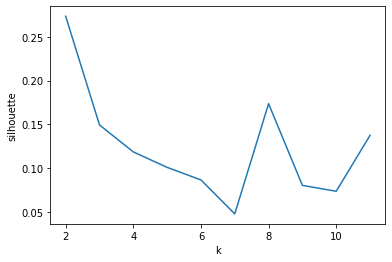

In [31]:
plt.plot(range_n_clusters,  silhouette)
plt.xlabel('k')
plt.ylabel('silhouette')

Text(0, 0.5, 'SDbw')

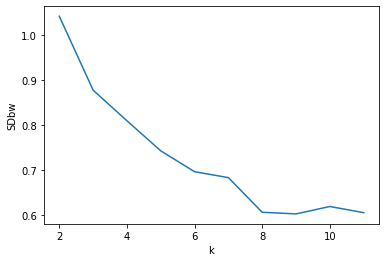

In [32]:
plt.plot(range_n_clusters,  SDbw)
plt.xlabel('k')
plt.ylabel('SDbw')

In [33]:
adjRSdf['GMM'] = adjRandSc
adjSltdf['GMM'] = silhouette
adjSDbwdf['GMM'] = SDbw
GMMDf = pd.DataFrame(adjRandSc, range_n_clusters, ['adj. Rand score'])
GMMDf['Silhouette'] = silhouette
GMMDf['S_Dbw'] = SDbw
GMMDf['BIC'] = bic
GMMDf

,adj. Rand score,Silhouette,S_Dbw,BIC
2,0.179709,0.273501,1.041844,-34724.495590
3,0.423786,0.149473,0.877344,-44768.015297
4,0.477593,0.118647,0.809198,-48698.168451
5,0.476437,0.101010,0.742275,-47694.750798
6,0.467898,0.086652,0.695820,-50019.130617
7,0.458877,0.047878,0.682631,-47862.634628
8,0.606292,0.173682,0.605536,-44192.265007
9,0.478412,0.080455,0.601864,-42775.705471
10,0.472718,0.073723,0.618399,-38447.402474
11,0.581414,0.137575,0.604649,-32092.467988


Отметим, что байесовский информационный критерий $BIC$ достиг минимального значения на "правильном" количестве кластеров. Индекс $adjusted\_rand\_score$ оказался немного ниже, а индекс $silhouette$ значительно ниже, чем при использовании метода kMeans.

## Иерархическая кластеризация

In [34]:
linkages = ["ward", "complete", "average", "single"]

aggClDf = pd.DataFrame(index=range_n_clusters)

adjRandSc = []
for n_clusters in range_n_clusters:
    sl = []
    for linkage in linkages:
        ac = AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage)
        labels = ac.fit_predict(X)
        sc = adjusted_rand_score(classes, labels)
        sl.append(sc)
    adjRandSc.append(np.max(sl)) 
aggClDf['adjRandSc'] = adjRandSc

silhouette = []
for n_clusters in range_n_clusters:
    sl = []
    for linkage in linkages:
        ac = AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage)
        labels = ac.fit_predict(X)
        sc = silhouette_score(X, labels)
        sl.append(sc)
    silhouette.append(np.max(sl)) 
aggClDf['silhouette'] = silhouette

SDbw = []
for n_clusters in range_n_clusters:
    sl = []
    for linkage in linkages:
        ac = AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage)
        labels = ac.fit_predict(X)
        sc = S_Dbw(X, labels)
        sl.append(sc)
    SDbw.append(np.min(sl)) 
aggClDf['S_Dbw'] = SDbw

adjRSdf['AggClust'] = adjRandSc
adjSltdf['AggClust'] = silhouette
adjSDbwdf['AggClust'] = SDbw

Text(0, 0.5, 'adjusted_rand_score')

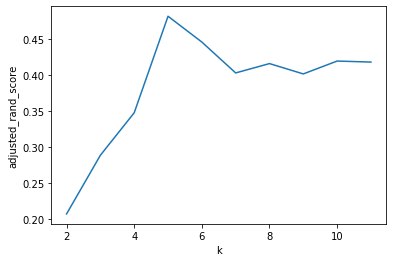

In [35]:
plt.plot(range_n_clusters,  adjRandSc)
plt.xlabel('k')
plt.ylabel('adjusted_rand_score')

Text(0, 0.5, 'silhouette')

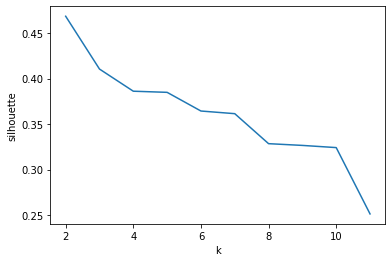

In [36]:
plt.plot(range_n_clusters,  silhouette)
plt.xlabel('k')
plt.ylabel('silhouette')

Text(0, 0.5, 'SDbw')

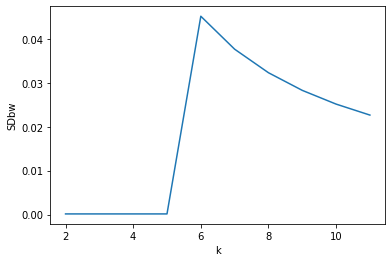

In [37]:
plt.plot(range_n_clusters,  SDbw)
plt.xlabel('k')
plt.ylabel('SDbw')

In [38]:
aggClDf

,adjRandSc,silhouette,S_Dbw
2,0.206617,0.468545,0.000155
3,0.288465,0.410508,0.000155
4,0.347686,0.386156,0.000155
5,0.482315,0.384911,0.000155
6,0.446303,0.364384,0.045135
7,0.403252,0.361469,0.037638
8,0.416282,0.328500,0.032284
9,0.401867,0.326587,0.028268
10,0.419825,0.324188,0.025144
11,0.418391,0.251299,0.022645


In [39]:
print('Adjusted Rand score')
adjRSdf

Adjusted Rand score


,kMeans,GMM,AggClust
2,0.191959,0.179709,0.206617
3,0.293505,0.423786,0.288465
4,0.459169,0.477593,0.347686
5,0.462151,0.476437,0.482315
6,0.529365,0.467898,0.446303
7,0.563240,0.458877,0.403252
8,0.431974,0.606292,0.416282
9,0.418721,0.478412,0.401867
10,0.456179,0.472718,0.419825
11,0.446201,0.581414,0.418391


In [40]:
print('Silhouette score')
adjSltdf

Silhouette score


,kMeans,GMM,AggClust
2,0.346910,0.273501,0.468545
3,0.437332,0.149473,0.410508
4,0.395397,0.118647,0.386156
5,0.331865,0.101010,0.384911
6,0.352249,0.086652,0.364384
7,0.331512,0.047878,0.361469
8,0.298151,0.173682,0.328500
9,0.281106,0.080455,0.326587
10,0.274483,0.073723,0.324188
11,0.278656,0.137575,0.251299


In [41]:
print('S_Dbw score')
adjSDbwdf

S_Dbw score


,kMeans,GMM,AggClust
2,0.750592,1.041844,0.000155
3,0.631317,0.877344,0.000155
4,0.559879,0.809198,0.000155
5,0.508784,0.742275,0.000155
6,0.478403,0.695820,0.045135
7,0.458585,0.682631,0.037638
8,0.440188,0.605536,0.032284
9,0.440011,0.601864,0.028268
10,0.425892,0.618399,0.025144
11,0.438713,0.604649,0.022645


По индексу $Ajusted Rand$  наилучший результат показал метод $kMeans$, по индексам $Silhouette$ и $S Dbw$ - метод $Agglomerative Clustering$.